In [1]:
!pip install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.7 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
import glob
import tensorflow as tf
import re
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,LeakyReLU,Add,Average,Lambda,MaxPool2D,Dropout,UpSampling2D,Concatenate,Multiply,Dense,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.layers import concatenate,Flatten,ConvLSTM2D,Layer,LayerNormalization,ReLU,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [3]:
normal_dir = "/content/drive/MyDrive/cleaned_dataset/Normal"
extensions = ["*.png", "*.jpeg", "*.jpg"]
normal_files = []
for ext in extensions:
    """Join the directory path with each extension and using glob.glob() to find matching files which are then
    appended to normal_files list"""
    normal_files.extend(glob.glob(os.path.join(normal_dir, ext)))

In [4]:
pneumonia_dir = "/content/drive/MyDrive/cleaned_dataset/Pneumonia"
extensions = ["*.png", "*.jpeg", "*.jpg"]
pneumonia_files = []
for ext in extensions:
    pneumonia_files.extend(glob.glob(os.path.join(pneumonia_dir, ext)))

In [5]:
covid_dir = "/content/drive/MyDrive/cleaned_dataset/Covid"
extensions = ["*.png", "*.jpeg", "*.jpg"]
covid_files = []
for ext in extensions:
    covid_files.extend(glob.glob(os.path.join(covid_dir, ext)))

In [6]:
normal_files.sort()
covid_files.sort()
pneumonia_files.sort()

In [7]:
# ~75% of each category is used in the training set
file_lists = [covid_files[:900], normal_files[:900], pneumonia_files[:900]]
labels = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
train_dic = {f: label for file_list, label in zip(file_lists, labels) for f in sorted(file_list)}

In [8]:
# In-place shuffling of training set with 3 as the seed of the random number generator
l = list(train_dic.items())
random.Random(3).shuffle(l)


In [9]:
# ~10% of each category is used in the validation set
file_lists = [covid_files[900:1020], normal_files[900:1020], pneumonia_files[900:1020]]
labels = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
val_dic = {f: label for file_list, label in zip(file_lists, labels) for f in sorted(file_list)}


In [10]:
# In-place shuffling of validation set with 4 as the seed of the random number generator
l_val = list(val_dic.items())
random.seed(4)
random.shuffle(l_val)

In [11]:
# ~15% of each category is used in the test set
file_lists = [covid_files[1020:1200], normal_files[1020:1200], pneumonia_files[1020:1200]]
labels = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
test_dic = {f: label for file_list, label in zip(file_lists, labels) for f in sorted(file_list)}

In [12]:
# In-place shuffling of testing set with 5 as the seed of the random number generator
l_test = list(test_dic.items())
random.Random(5).shuffle(l_test)


In [13]:
print(len(l_val),len(l_test))

360 540


In [14]:
data = []
labels = []
for f,label in l:
  img = cv2.imread(f)
  img = img.astype('float32')/255.0 # Normalize the image
  data.append(img)
  labels.append(label)

train_data = np.array(data)
train_labels = np.array(labels)
print(train_data.shape)
print(train_labels.shape)
print('Training set preparation completed')

(2700, 224, 224, 3)
(2700, 3)
Training set preparation completed


In [15]:
data = []
labels = []

for f, label in l_val:
    # Read and normalize image
    img = cv2.imread(f)
    img = img.astype('float')/255.0
    data.append(img)
    labels.append(label)

# Cast lists to numpy arrays
val_data = np.array(data)
val_labels = np.array(labels)

print(val_data.shape)
print(val_labels.shape)
print("Validation set preparation completed")

(360, 224, 224, 3)
(360, 3)
Validation set preparation completed


In [16]:
data = []
labels = []
for f,label in l_test:
  img = cv2.imread(f)
  img = img.astype('float32')/255.0
  data.append(img)
  labels.append(label)

test_data = np.array(data)
test_labels = np.array(labels)
print(test_data.shape)
print(test_labels.shape)
print('Testing set preparation completed')

(540, 224, 224, 3)
(540, 3)
Testing set preparation completed


In [17]:

class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

Densenet_pred = load_model('/content/drive/MyDrive/Models/Densenet.h5',custom_objects={'ExpandDimsLayer': ExpandDimsLayer})

In [18]:

class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)
vgg_pred = load_model('/content/drive/MyDrive/Models/vgg.h5',custom_objects={'ExpandDimsLayer': ExpandDimsLayer})


In [19]:

class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)
mobile_pred = load_model('/content/drive/MyDrive/Models/mobile.h5',custom_objects={'ExpandDimsLayer': ExpandDimsLayer})

In [20]:

class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)
resnet_pred = load_model('/content/drive/MyDrive/Models/resnet.h5',custom_objects={'ExpandDimsLayer': ExpandDimsLayer})

In [21]:
Densenet_pred.evaluate(val_data,val_labels)
vgg_pred.evaluate(val_data,val_labels)
mobile_pred.evaluate(val_data,val_labels)
resnet_pred.evaluate(val_data,val_labels)

12/12 [==============================] - 6s 412ms/step - loss: 0.1194 - accuracy: 0.9694 - precision_3: 0.9694 - recall_3: 0.9694


[0.1194312646985054,
 0.9694444537162781,
 0.9694444537162781,
 0.9694444537162781]

In [22]:
val_den = Densenet_pred.predict(val_data)
val_vgg = vgg_pred.predict(val_data)
val_mob = mobile_pred.predict(val_data)
val_res = resnet_pred.predict(val_data)

12/12 [==============================] - 6s 418ms/step


In [37]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

y_val_true_label_encoded = np.argmax(val_labels, axis=1)
y_val_models = [np.argmax(val_den,axis=1),np.argmax(val_vgg,axis=1),np.argmax(val_mob,axis=1),np.argmax(val_res,axis=1)]
accuracy_scores_model = [accuracy_score(y_val_true_label_encoded, _) for _ in y_val_models]
print("The accuracy on validation set of Densenet, VGG, Mobilenet, Resnet are:\n")
print(accuracy_scores_model)
# Weights chosen experimentally on validation data
chosen_weights = [1,1.5,1.2,1.1]

# Multiply each prediction array with corresponding weight
result_model = np.stack([s * v for s, v in zip(chosen_weights, [val_den, val_vgg, val_mob, val_res])])
final_predictions_val_one_hot = np.mean(result_model, axis=0)
y_val_pred_label_encoded = np.argmax(final_predictions_val_one_hot,axis=1)

# Calculate accuracy and print the classification report
accuracy_val = accuracy_score(y_val_true_label_encoded, y_val_pred_label_encoded)
print(f'Validation Accuracy: {accuracy_val}')
report_val = classification_report(y_val_true_label_encoded, y_val_pred_label_encoded,
               labels=[0, 1, 2], target_names=['Covid', 'Normal', 'Pneumonia'])
print(report_val)

The accuracy on validation set of Densenet, VGG, Mobilenet, Resnet are:

[0.9805555555555555, 0.9861111111111112, 0.9805555555555555, 0.9694444444444444]
Validation Accuracy: 0.9944444444444445
              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00       120
      Normal       1.00      0.98      0.99       120
   Pneumonia       0.98      1.00      0.99       120

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



Confusion Matrix of Validation Set:
[[120   0   0]
 [  0 118   2]
 [  0   0 120]]


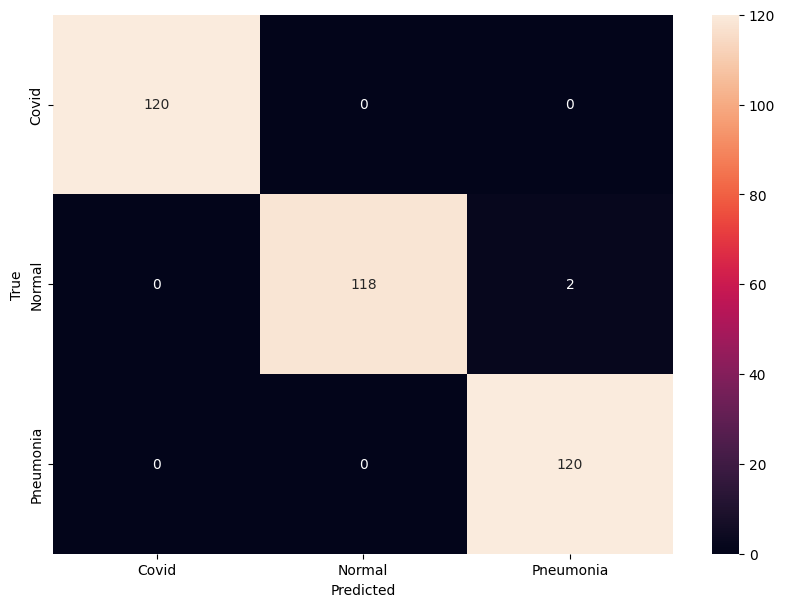

In [38]:
cm_val = confusion_matrix(y_val_true_label_encoded, y_val_pred_label_encoded)

# Print the confusion matrix
print('Confusion Matrix of Validation Set:')
print(cm_val)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=['Covid', 'Normal', 'Pneumonia'],
            yticklabels=['Covid', 'Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
Densenet_pred.evaluate(test_data,test_labels)
vgg_pred.evaluate(test_data,test_labels)
mobile_pred.evaluate(test_data,test_labels)
resnet_pred.evaluate(test_data,test_labels)

17/17 [==============================] - 8s 440ms/step - loss: 0.2355 - accuracy: 0.9704 - precision_3: 0.9704 - recall_3: 0.9704


[0.23553596436977386, 0.970370352268219, 0.970370352268219, 0.970370352268219]

In [26]:
test_den = Densenet_pred.predict(test_data)
test_vgg = vgg_pred.predict(test_data)
test_mob = mobile_pred.predict(test_data)
test_res = resnet_pred.predict(test_data)


17/17 [==============================] - 8s 446ms/step


In [39]:
# Each model's softmax output is multiplied by corresponding weight
softmax_outputs_test = np.stack([s * v for s, v in zip(chosen_weights, [test_den, test_vgg, test_mob, test_res])])
final_predictions_test_one_hot = np.mean(softmax_outputs_test, axis=0)

# Convert one-hot encoded labels and predictions to label-encoded form
y_test_true_label_encoded = np.argmax(test_labels, axis=1)
y_test_pred_label_encoded = np.argmax(final_predictions_test_one_hot, axis=1)

y_test_pred_models = [np.argmax(test_den,axis=1),np.argmax(test_vgg,axis=1),np.argmax(test_mob,axis=1),np.argmax(test_res,axis=1)]
accuracy_models_test = [accuracy_score(mid,y_test_true_label_encoded) for mid in y_test_pred_models]
print("The accuracy on Test set of Densenet, VGG, Mobilenet, Resnet are:\n")
print(accuracy_models_test)

# Calculate accuracy and print the classification report
accuracy_test = accuracy_score(y_test_true_label_encoded, y_test_pred_label_encoded)
print(f'Accuracy: {accuracy_test}')
report_test = classification_report(y_test_true_label_encoded, y_test_pred_label_encoded,
               labels=[0, 1, 2], target_names=['Covid', 'Normal', 'Pneumonia'])
print(report_test)

The accuracy on Test set of Densenet, VGG, Mobilenet, Resnet are:

[0.9592592592592593, 0.9629629629629629, 0.9481481481481482, 0.9703703703703703]
Accuracy: 0.9722222222222222
              precision    recall  f1-score   support

       Covid       0.99      0.99      0.99       180
      Normal       0.98      0.94      0.96       180
   Pneumonia       0.95      0.98      0.97       180

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540



Confusion Matrix of Test Set:
[[178   2   0]
 [  1 170   9]
 [  1   2 177]]


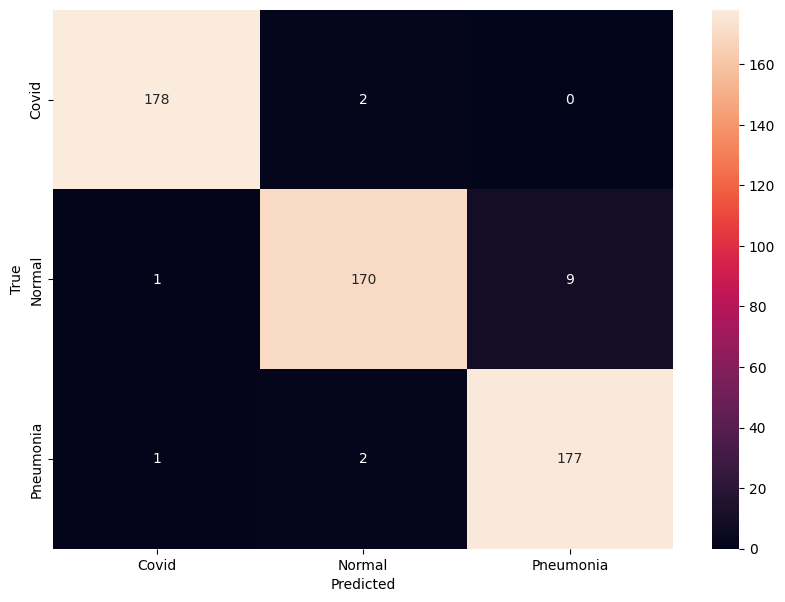

In [40]:
cm_test = confusion_matrix(y_test_true_label_encoded, y_test_pred_label_encoded)

# Print the confusion matrix
print('Confusion Matrix of Test Set:')
print(cm_test)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=['Covid', 'Normal', 'Pneumonia'],
            yticklabels=['Covid', 'Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [41]:
train_den = Densenet_pred.predict(train_data)
train_vgg = vgg_pred.predict(train_data)
train_mob = mobile_pred.predict(train_data)
train_res = resnet_pred.predict(train_data)

85/85 [==============================] - 37s 434ms/step


In [42]:
# Each model's softmax output is multiplied by corresponding weight
softmax_outputs_train = np.stack([s * v for s, v in zip(chosen_weights, [train_den, train_vgg, train_mob, train_res])])
final_predictions_train_one_hot = np.mean(softmax_outputs_train, axis=0)

# Convert one-hot encoded labels and predictions to label-encoded form
y_train_true_label_encoded = np.argmax(train_labels, axis=1)
y_train_pred_label_encoded = np.argmax(final_predictions_train_one_hot, axis=1)

y_train_pred_models = [np.argmax(train_den,axis=1),np.argmax(train_vgg,axis=1),np.argmax(train_mob,axis=1),np.argmax(train_res,axis=1)]
accuracy_models_train = [accuracy_score(mid,y_train_true_label_encoded) for mid in y_train_pred_models]
print("The accuracy on Training set of Densenet, VGG, Mobilenet, Resnet are:\n")
print(accuracy_models_train)

# Calculate accuracy and print the classification report
accuracy_train = accuracy_score(y_train_true_label_encoded, y_train_pred_label_encoded)
print(f'Accuracy: {accuracy_train}')
report_test = classification_report(y_train_true_label_encoded, y_train_pred_label_encoded,
               labels=[0, 1, 2], target_names=['Covid', 'Normal', 'Pneumonia'])
print(report_test)

The accuracy on Training set of Densenet, VGG, Mobilenet, Resnet are:

[1.0, 1.0, 0.9996296296296296, 0.9996296296296296]
Accuracy: 1.0
              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00       900
      Normal       1.00      1.00      1.00       900
   Pneumonia       1.00      1.00      1.00       900

    accuracy                           1.00      2700
   macro avg       1.00      1.00      1.00      2700
weighted avg       1.00      1.00      1.00      2700



Confusion Matrix of Training Set:
[[900   0   0]
 [  0 900   0]
 [  0   0 900]]


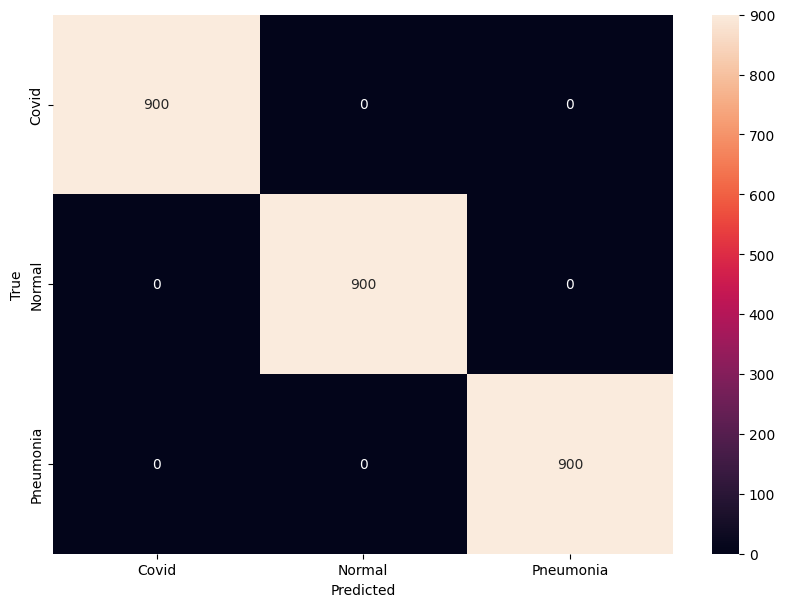

In [43]:
cm_train = confusion_matrix(y_train_true_label_encoded, y_train_pred_label_encoded)

# Print the confusion matrix
print('Confusion Matrix of Training Set:')
print(cm_train)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=['Covid', 'Normal', 'Pneumonia'],
            yticklabels=['Covid', 'Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Confusion Matrix of Total Corpus:
[[1198    2    0]
 [   1 1188   11]
 [   1    2 1197]]


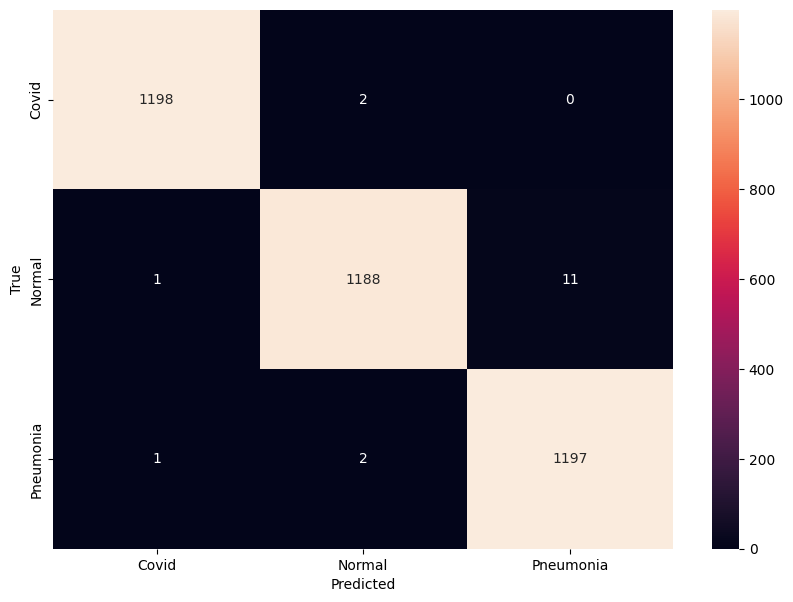

In [44]:
cm_total = cm_train + cm_test + cm_val

# Print the confusion matrix
print('Confusion Matrix of Total Corpus:')
print(cm_total)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_total, annot=True, fmt='d', xticklabels=['Covid', 'Normal', 'Pneumonia'],
            yticklabels=['Covid', 'Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()